In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd


# Fitting model on imbalanced datasets and how to fight bias


This example illustrates the problem induced by learning on datasets having
imbalanced classes. Subsequently, we compare different approaches alleviating
these negative effects.


In [6]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

print(__doc__)

Automatically created module for IPython interactive environment


In [7]:
def sigmoid(x): return 1./(1. +  np.exp(-x))

def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess

def lgb_focal_f1_score(preds, lgbDataset):
    """
    When using custom losses the row prediction needs to passed through a
    sigmoid to represent a probability

    Parameters:
    -----------
    preds: numpy.ndarray
        array with the predictions
    lgbDataset: lightgbm.Dataset
    """
    preds = sigmoid(preds)
    binary_preds = [int(p>=0.5) for p in preds]
    y_true = lgbDataset.get_label()
    return 'f1', f1_score(y_true, binary_preds), True

Problem definition
##############################################################################



In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd

# df = pd.read_csv("C:/Users/xtbury/Documents/Projects/imblearn/adult.csv")
# y = df['target'].copy()
# df = df.drop(columns=['target'])

# df, y = fetch_openml('adult', version=2, as_frame=True, return_X_y=True)
# # we are dropping the following features:
# # - "fnlwgt": this feature was created while studying the "adult" dataset.
# #   Thus, we will not use this feature which is not acquired during the survey.
# # - "education-num": it is encoding the same information than "education".
# #   Thus, we are removing one of these 2 features.
# df = df.drop(columns=['fnlwgt', 'education-num'])

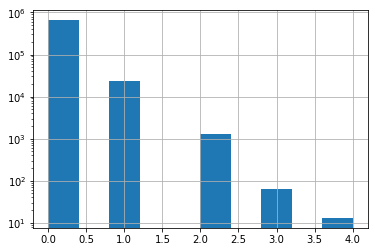

In [116]:
import pyarrow.parquet as pq
import pyarrow as pa
dataset_path = "C:/Users/[user_id]/Documents/demo/french_tpl.parquet"
ins_df = pq.read_table(dataset_path).to_pandas()
ins_df = ins_df.convert_dtypes()

predictors = ['Area','VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']
cat_f = ['Area', 'VehBrand', 'VehGas', 'Region']

num_cols = list(set(predictors) - set(cat_f))
ins_df[num_cols] = ins_df[num_cols].astype(np.float64)
y = ins_df ['ClaimNb'].copy()
y = y.fillna(0)
y = (1*(ins_df ['ClaimNb'] > 0)).astype(np.int64)
df = ins_df[predictors].copy()
df[cat_f] = df[cat_f].astype("category")

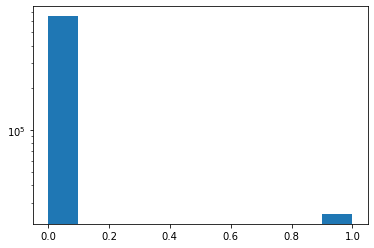

In [117]:
plt.hist(y)
plt.yscale('log')

The dataset as a class ratio of about 26:1



In [118]:
classes_count = y.value_counts()
classes_count

0    653069
1     24944
Name: ClaimNb, dtype: int64

This dataset is only slightly imbalanced. To better highlight the effect of
learning from an imbalanced dataset, we will increase its ratio to 30:1



In [119]:
# claims is unbalanced
y_res = y
df_res = df

For the rest of the notebook, we will make a single split to get training
and testing data. Note that you should use cross-validation to have an
estimate of the performance variation in practice.



In [120]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_res, y_res, stratify=y_res, random_state=42
)

As a baseline, we could use a classifier which will always predict the
majority class independently of the features provided.



In [121]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
score = dummy_clf.fit(X_train, y_train).score(X_test, y_test)
print(f"Accuracy score of a dummy classifier: {score:.3f}")

Accuracy score of a dummy classifier: 0.963


Instead of using the accuracy, we can use the balanced accuracy which will
take into account the balancing issue.



In [122]:
from sklearn.metrics import balanced_accuracy_score

y_pred = dummy_clf.predict(X_test)
score = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy score of a dummy classifier: {score:.3f}")

Balanced accuracy score of a dummy classifier: 0.500


Strategies to learn from an imbalanced dataset
##############################################################################



We will first define a helper function which will train a given model
and compute both accuracy and balanced accuracy. The results will be stored
in a dataframe



In [123]:
import pandas as pd


def evaluate_classifier(clf, df_scores, clf_name=None):
    from sklearn.pipeline import Pipeline
    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    y_pred = np.asarray(y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    clf_score = pd.DataFrame(
        {clf_name: [acc, bal_acc]},
        index=['Accuracy', 'Balanced accuracy']
    )
    df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=3)
    return df_scores


# Let's define an empty dataframe to store the results
df_scores = pd.DataFrame()

Dummy baseline
..............

Before to train a real machine learning model, we can store the results
obtained with our `DummyClassifier`.



In [124]:
df_scores = evaluate_classifier(dummy_clf, df_scores, "Dummy")
df_scores

,Dummy
Accuracy,0.963
Balanced accuracy,0.500


Linear classifier baseline
..........................

We will create a machine learning pipeline using a `LogisticRegression`
classifier. In this regard, we will need to one-hot encode the categorical
columns and standardized the numerical columns before to inject the data into
the `LogisticRegression` classifier.

First, we define our numerical and categorical pipelines.



In [125]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline

num_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder() #OneHotEncoder(handle_unknown="ignore")
)

Then, we can create a preprocessor which will dispatch the categorical
columns to the categorical pipeline and the numerical columns to the
numerical pipeline



In [126]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

preprocessor_linear = ColumnTransformer(
    [("num-pipe", num_pipe, selector(dtype_include=np.number)),
     ("cat-pipe", cat_pipe, selector(dtype_include=pd.CategoricalDtype))],
    n_jobs=2
)

Finally, we connect our preprocessor with our `LogisticRegression`. We can
then evaluate our model.



In [127]:
from sklearn.linear_model import LogisticRegression

lr_clf = make_pipeline(
    preprocessor_linear, LogisticRegression(max_iter=1000)
)
df_scores = evaluate_classifier(lr_clf, df_scores, "LR")
df_scores

,Dummy,LR
Accuracy,0.963,0.963
Balanced accuracy,0.500,0.500


We can see that our linear model is learning slightly better than our dummy
baseline. However, it is impacted by the class imbalance.

We can verify that something similar is happening with a tree-based model
such as `RandomForestClassifier`. With this type of classifier, we will not
need to scale the numerical data, and we will only need to ordinal encode the
categorical data.



In [128]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder()
)

preprocessor_tree = ColumnTransformer(
    [("num-pipe", num_pipe, selector(dtype_include=np.number)),
     ("cat-pipe", cat_pipe, selector(dtype_include=pd.CategoricalDtype))],
    n_jobs=2
)

rf_clf = make_pipeline(
    preprocessor_tree, RandomForestClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(rf_clf, df_scores, "RF")
df_scores

,Dummy,LR,RF
Accuracy,0.963,0.963,0.957
Balanced accuracy,0.500,0.500,0.502


In [129]:
from lightgbm import LGBMClassifier

cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder()
)

preprocessor_tree = ColumnTransformer(
    [("num-pipe", num_pipe, selector(dtype_include=np.number)),
     ("cat-pipe", cat_pipe, selector(dtype_include=pd.CategoricalDtype))],
    n_jobs=2
)

lgb_clf = make_pipeline(
    preprocessor_tree, LGBMClassifier(random_state=42, n_jobs=-1)
)

df_scores = evaluate_classifier(lgb_clf, df_scores, "LGB")
df_scores

,Dummy,LR,RF,LGB
Accuracy,0.963,0.963,0.957,0.963
Balanced accuracy,0.500,0.500,0.502,0.500


In [133]:
from catboost import CatBoostClassifier
cat_clf = CatBoostClassifier(random_state=42, cat_features=cat_f, verbose=0)

df_scores = evaluate_classifier(
    cat_clf, df_scores, "Cat"
)
df_scores

,Dummy,LR,RF,LGB,Cat
Accuracy,0.963,0.963,0.957,0.963,0.963
Balanced accuracy,0.500,0.500,0.502,0.500,0.500


The `RandomForestClassifier` is as well affected by the class imbalanced,
slightly less than the linear model. Now, we will present different approach
to improve the performance of these 2 models.

Use `class_weight`
..................

Most of the models in `scikit-learn` have a parameter `class_weight`. This
parameter will affect the computation of the loss in linear model or the
criterion in the tree-based model to penalize differently a false
classification from the minority and majority class. We can set
`class_weight="balanced"` such that the weight applied is inversely
proportional to the class frequency. We test this parametrization in both
linear model and tree-based model.



In [134]:
lr_clf.set_params(logisticregression__class_weight="balanced")
df_scores = evaluate_classifier(
    lr_clf, df_scores, "LR CW"
)
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566


In [135]:
rf_clf.set_params(randomforestclassifier__class_weight="balanced")
df_scores = evaluate_classifier(
    rf_clf, df_scores, "RF CW"
)
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW,RF CW
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666,0.954
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566,0.500


In [136]:
from lightgbm import LGBMClassifier

lgb_clf = LGBMClassifier(random_state=42, n_jobs=2, class_weight='balanced')

df_scores = evaluate_classifier(
    lgb_clf, df_scores, "LGB CW"
)
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW,RF CW,LGB CW
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666,0.954,0.690
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566,0.500,0.607


In [137]:
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

cat_clf = CatBoostClassifier(random_state=42, cat_features=cat_f, class_weights=class_weights, verbose=0)

df_scores = evaluate_classifier(
    cat_clf, df_scores, "Cat CW"
)
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW,RF CW,LGB CW,Cat CW
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666,0.954,0.690,0.703
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566,0.500,0.607,0.601


We can see that using `class_weight` was really effective for the linear
model, alleviating the issue of learning from imbalanced classes. However,
the `RandomForestClassifier` is still biased toward the majority class,
mainly due to the criterion which is not suited enough to fight the class
imbalance.

Resample the training set during learning
.........................................

Another way is to resample the training set by under-sampling or
over-sampling some of the samples. `imbalanced-learn` provides some samplers
to do such processing.



In [138]:
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler

lr_clf = make_pipeline_with_sampler(
    preprocessor_linear,
    RandomUnderSampler(random_state=42),
    LogisticRegression(max_iter=1000)
)
df_scores = evaluate_classifier(
    lr_clf, df_scores, "LR US"
)
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW,RF CW,LGB CW,Cat CW,LR US
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666,0.954,0.690,0.703,0.663
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566,0.500,0.607,0.601,0.566


In [139]:
rf_clf = make_pipeline_with_sampler(
    preprocessor_tree,
    RandomUnderSampler(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(
    rf_clf, df_scores, "RF US"
)
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW,RF CW,LGB CW,Cat CW,LR US,RF US
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666,0.954,0.690,0.703,0.663,0.604
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566,0.500,0.607,0.601,0.566,0.578


In [140]:
from lightgbm import LGBMClassifier
lgb_clf = make_pipeline_with_sampler(
    preprocessor_tree,
    RandomUnderSampler(random_state=42),
    LGBMClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(
    lgb_clf, df_scores, "LGB US"
)
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW,RF CW,LGB CW,Cat CW,LR US,RF US,LGB US
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666,0.954,0.690,0.703,0.663,0.604,0.663
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566,0.500,0.607,0.601,0.566,0.578,0.602


In [141]:
from catboost import CatBoostClassifier
lgb_clf = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=42),
    CatBoostClassifier(random_state=42, cat_features=cat_f, verbose=0)
)

df_scores = evaluate_classifier(
    cat_clf, df_scores, "Cat US"
)
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW,RF CW,LGB CW,Cat CW,LR US,RF US,LGB US,Cat US
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666,0.954,0.690,0.703,0.663,0.604,0.663,0.703
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566,0.500,0.607,0.601,0.566,0.578,0.602,0.601


Applying a random under-sampler before the training of the linear model or
random forest, allows to not focus on the majority class at the cost of
making more mistake for samples in the majority class (i.e. decreased
accuracy).

We could apply any type of samplers and find which sampler is working best
on the current dataset.

Instead, we will present another way by using classifiers which will apply
sampling internally.

Use of `BalancedRandomForestClassifier` and `BalancedBaggingClassifier`
.......................................................................

We already showed that random under-sampling can be effective on decision
tree. However, instead of under-sampling once the dataset, one could
under-sample the original dataset before to take a bootstrap sample. This is
the base of the `BalancedRandomForestClassifier` and
`BalancedBaggingClassifier`.



In [142]:
from imblearn.ensemble import BalancedRandomForestClassifier

rf_clf = make_pipeline(
    preprocessor_tree,
    BalancedRandomForestClassifier(random_state=42, n_jobs=2)
)

df_scores = evaluate_classifier(rf_clf, df_scores, "RF Bal")
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW,RF CW,LGB CW,Cat CW,LR US,RF US,LGB US,Cat US,RF Bal
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666,0.954,0.690,0.703,0.663,0.604,0.663,0.703,0.632
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566,0.500,0.607,0.601,0.566,0.578,0.602,0.601,0.591


The performance with the `BalancedRandomForestClassifier` is better than
applying a single random under-sampling. We will use a gradient-boosting
classifier within a `BalancedBaggingClassifier`.



In [143]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

bag_clf = make_pipeline(
    preprocessor_tree,
    BalancedBaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(random_state=42),
        n_estimators=10, random_state=42, n_jobs=2
    )
)

df_scores = evaluate_classifier(
    bag_clf, df_scores, "Bagging Bal"
)
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW,RF CW,LGB CW,Cat CW,LR US,RF US,LGB US,Cat US,RF Bal,Bagging Bal
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666,0.954,0.690,0.703,0.663,0.604,0.663,0.703,0.632,0.690
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566,0.500,0.607,0.601,0.566,0.578,0.602,0.601,0.591,0.605


This last approach is the most effective. The different under-sampling allows
to bring some diversity for the different GBDT to learn and not focus on a
portion of the majority class.

We will repeat the same experiment but with a ratio of 100:1 and make a
similar analysis.



In [144]:
from lightgbm import LGBMClassifier

bag_clf = make_pipeline(
    preprocessor_tree,
    BalancedBaggingClassifier(
        base_estimator=LGBMClassifier(random_state=42),
        n_estimators=50, random_state=42, n_jobs=2
    )
)

df_scores = evaluate_classifier(
    bag_clf, df_scores, "LGB Bal"
)
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW,RF CW,LGB CW,Cat CW,LR US,RF US,LGB US,Cat US,RF Bal,Bagging Bal,LGB Bal
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666,0.954,0.690,0.703,0.663,0.604,0.663,0.703,0.632,0.690,0.690
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566,0.500,0.607,0.601,0.566,0.578,0.602,0.601,0.591,0.605,0.607


In [145]:
bag_clf = make_pipeline(
    preprocessor_tree,
    BalancedBaggingClassifier(
        base_estimator=CatBoostClassifier(random_state=42, verbose=0),
        n_estimators=10, random_state=42, n_jobs=2
    )
)

df_scores = evaluate_classifier(
    bag_clf, df_scores, "Cat Bal"
)
df_scores

,Dummy,LR,RF,LGB,Cat,LR CW,RF CW,LGB CW,Cat CW,LR US,RF US,LGB US,Cat US,RF Bal,Bagging Bal,LGB Bal,Cat Bal
Accuracy,0.963,0.963,0.957,0.963,0.963,0.666,0.954,0.690,0.703,0.663,0.604,0.663,0.703,0.632,0.690,0.690,0.683
Balanced accuracy,0.500,0.500,0.502,0.500,0.500,0.566,0.500,0.607,0.601,0.566,0.578,0.602,0.601,0.591,0.605,0.607,0.604


Increase imbalanced ratio
##############################################################################



When we analyse the results, we can draw similar conclusions than in the
previous discussion. However, we can observe that the strategy
`class_weight="balanced"` does not improve the performance when using a
`RandomForestClassifier`. A resampling is indeed required. The most effective
method remains the `BalancedBaggingClassifier` using a GBDT as a base
learner.

